<a href="https://colab.research.google.com/github/varshithgoud2407/Varshithgoud/blob/main/credit_card_fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive
Dataset Shape: (284807, 31)
                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.168375e-15  3.416908e-16 -1.379537e-15  2.074095e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   9.604066e-16  1.487313e-15 -5.556467e-16  1.213481e-16 -2.40

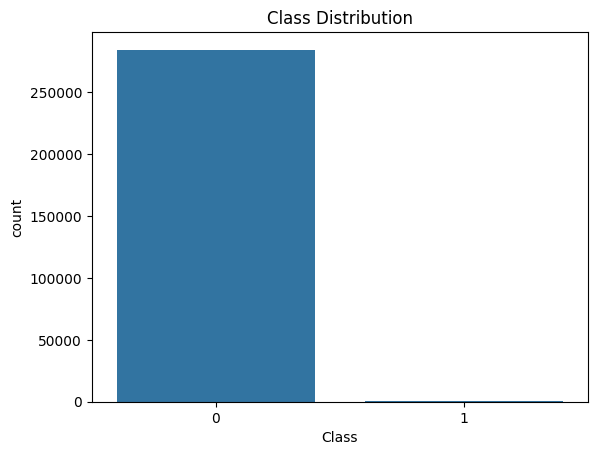

After SMOTE:
 Class
0    284315
1    284315
Name: count, dtype: int64

Training: Logistic Regression


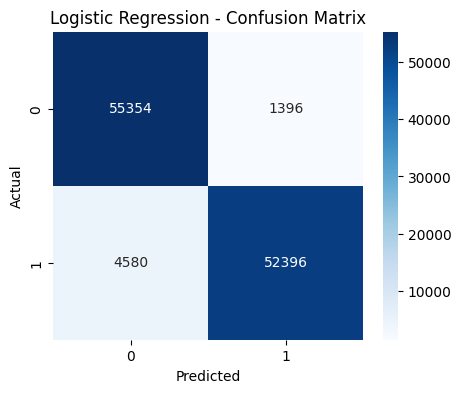

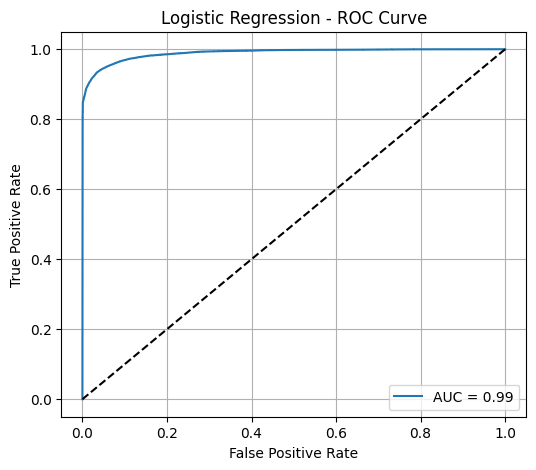

Logistic Regression - Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95     56750
           1       0.97      0.92      0.95     56976

    accuracy                           0.95    113726
   macro avg       0.95      0.95      0.95    113726
weighted avg       0.95      0.95      0.95    113726


Training: Random Forest


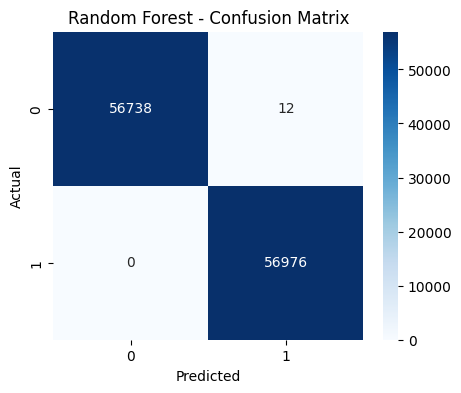

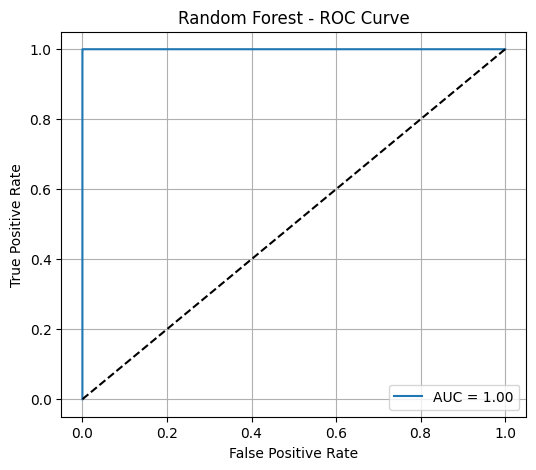

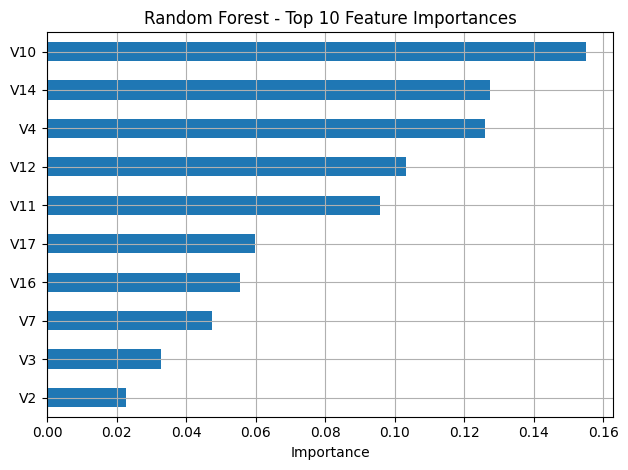

Random Forest - Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56750
           1       1.00      1.00      1.00     56976

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726


Training: XGBoost


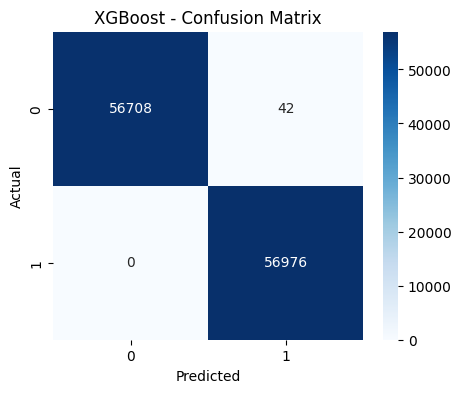

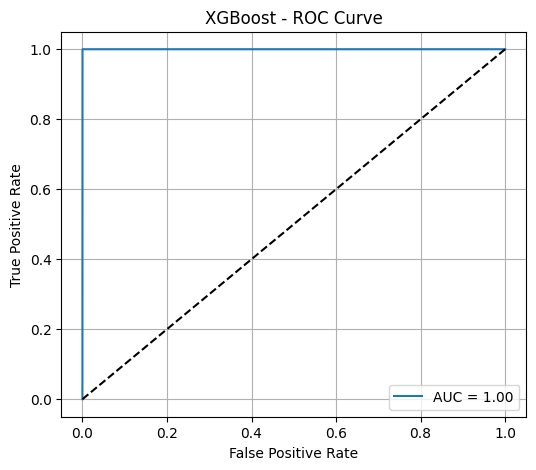

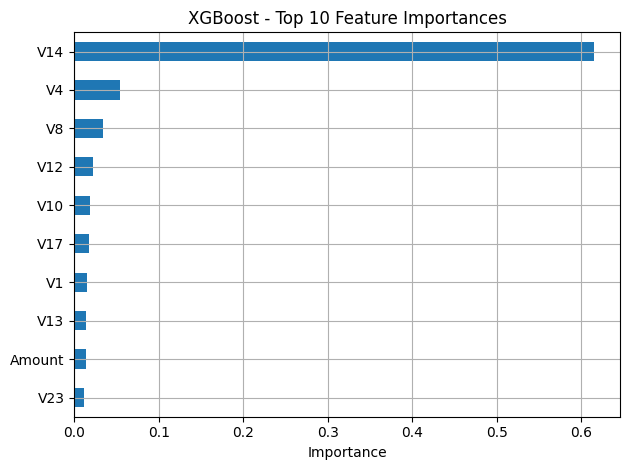

XGBoost - Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56750
           1       1.00      1.00      1.00     56976

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726



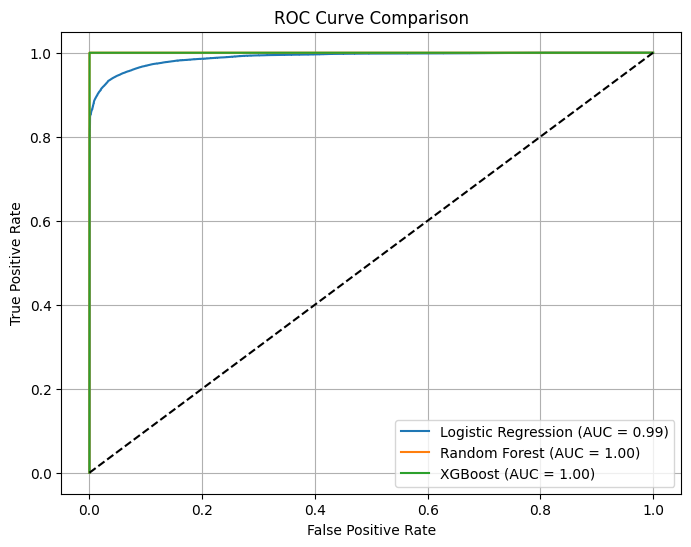


Best Model: Random Forest with AUC = 1.0000


In [ ]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')


# Step 2: Load Dataset
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/MyDrive/ML_assignment/creditcard.csv")
print("Dataset Shape:", df.shape)

# Step 3: EDA
print(df.describe())
print(df['Class'].value_counts())

# Class distribution plot
sns.countplot(x='Class', data=df)
plt.title('Class Distribution')
plt.show()

# Step 4: Preprocessing
X = df.drop(['Class', 'Time'], axis=1)
y = df['Class']

# Normalize 'Amount'
scaler = StandardScaler()
X['Amount'] = scaler.fit_transform(X['Amount'].values.reshape(-1, 1))

# Step 5: Handle Class Imbalance with SMOTE
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X, y)
print("After SMOTE:\n", y_resampled.value_counts())

# Step 6: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Step 7: Initialize Models
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

results = {}

# Step 8: Training, Evaluation, and Visualization
for name, model in models.items():
    print(f"\nTraining: {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Metrics
    cm = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    fpr, tpr, _ = roc_curve(y_test, y_proba)

    # Store results
    results[name] = {'model': model, 'cm': cm, 'report': cr, 'auc': auc, 'fpr': fpr, 'tpr': tpr}

    # Confusion Matrix Visualization
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # ROC Curve Visualization
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{name} - ROC Curve')
    plt.legend()
    plt.grid()
    plt.show()

    # Feature Importance Visualization
    if name in ["Random Forest", "XGBoost"]:
        feature_importances = pd.Series(model.feature_importances_, index=X.columns)
        feature_importances.nlargest(10).plot(kind='barh')
        plt.title(f'{name} - Top 10 Feature Importances')
        plt.xlabel('Importance')
        plt.gca().invert_yaxis()
        plt.grid()
        plt.tight_layout()
        plt.show()

    # Print classification report
    print(f"{name} - Classification Report:\n{cr}")

# Step 9: Compare Models by ROC
plt.figure(figsize=(8, 6))
for name, res in results.items():
    plt.plot(res['fpr'], res['tpr'], label=f"{name} (AUC = {res['auc']:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid()
plt.show()

# Step 10: Best Model Summary
best_model = max(results.items(), key=lambda x: x[1]['auc'])
print(f"\nBest Model: {best_model[0]} with AUC = {best_model[1]['auc']:.4f}")